In [1]:
import torch
import matplotlib.pyplot as plt
%matplotlib inline

Read in the data

In [2]:
names = open('/Users/charlie/ML/datasets/names.txt', 'r').read().splitlines()

In [3]:
min(len(n) for n in names)

2

In [4]:
max(len(n) for n in names)

15

Build the bigram dictionary and store into a Tensor

In [88]:
N = torch.zeros((27, 27))

In [77]:
chars = sorted(list(set(''.join(names))))

In [78]:
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0

In [79]:
itos = {i:s for s,i in stoi.items()}

#### Training The Model

Fill the tensor with the bigram counts

In [89]:
for n in names:
    chs = ['.'] + list(n) + ['.']
    for ch1, ch2 in zip(chs, chs[1:]):
        ix1 = stoi[ch1]
        ix2 = stoi[ch2]
        N[ix1, ix2] += 1

Visualizing the bigram tensor

(-0.5, 26.5, 26.5, -0.5)

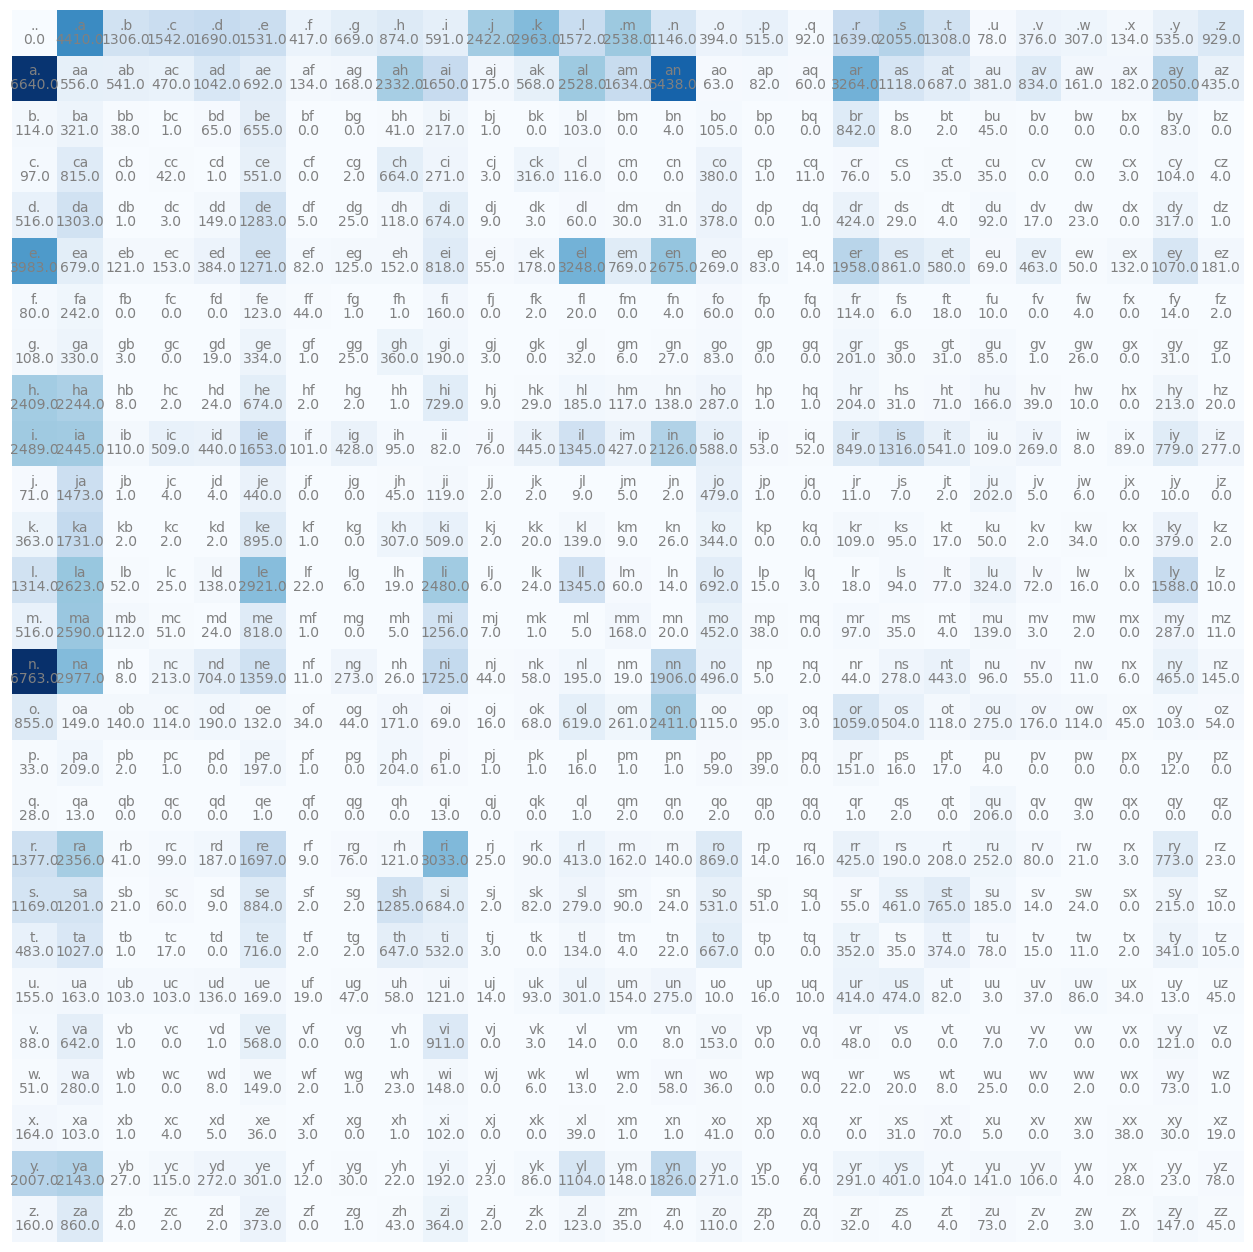

In [90]:
plt.figure(figsize=(16, 16))
plt.imshow(N, cmap="Blues")
for i in range(27):
    for j in range(27):
        chstr = itos[i] + itos[j]
        plt.text(j, i, chstr, ha="center", va="bottom", color="gray")
        plt.text(j, i, N[i,j].item(), ha="center", va="top", color="gray")
plt.axis('off')

Sampling from the distrbution vectors using `torch.multinomial`

In [91]:
p = N[0]
p = p / p.sum()
g = torch.Generator().manual_seed(2147483647)
ix = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()
itos[ix]

'c'

Upon closer inspection, N is 27,27 tensor and N.sum(1) is a 27,1 tensor

This division operation is allowed due to broadcasting rules implemented in PyTorch

[Broadcasting Semantics](https://pytorch.org/docs/stable/notes/broadcasting.html?highlight=broadcast)

In [130]:
# (N + 1) is required, known as model smoothing, otherwise there are bigrams that will have a log liklihood of -inf
P = (N+1) / N.sum(1, keepdim=True)

Generating some names using the bigram model

In [131]:
g = torch.Generator().manual_seed(2147483647)
for i in range(5):
    out = []
    ix = 0
    while True:
        p = P[ix]
        ix = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()
        out.append(itos[ix])
        if ix == 0: # end token
            break
    print(''.join(out))



cexze.
momasurailezitynn.
konimittain.
llayn.
ka.


Now we want to understand the quality of the model. This can be done by looking at the bigrams of our test data and inspecting the probability of the bigram in the model.

For a bit of intuition about if our model is giving us meaningful results, since there are 27 possible characters, we would expect the probability of a bigram to be `1/27 = 0.037`. So we can use this as a baseline to compare our model to.

[Maximum Likelihood Estimation](https://en.wikipedia.org/wiki/Maximum_likelihood_estimation)

The likelihood of a bigram is the probability of the bigram in the model. The likelihood of a sequence of bigrams is the product of the likelihood of each bigram. This product, is a small number typically so it is a bit troublesome to work with so people will use the log likelihood instead, whic is the sum of the log likelihood of each bigram.

[WolframAlpha Log Function](https://www.wolframalpha.com/input?i=log%28x%29+from+0+to+1)

Goal: Maximize the log likelihood of the test data with respect to model parameters, which are the bigram probabilities visible in the table visualization above (statistical modeling).
* Equivalent to maximizing the log likelihood (because the log function is monotonic)
* Equivalent to minimizing the negative log likelihood
* Equivalent to minimizing the average log likelihood

`log(a*b*c) = log(a) + log(b) + log(c)`

In [138]:
log_likelihood = 0.0
n = 0
for name in names:
    chs = ['.'] + list(name) + ['.']
    for ch1, ch2 in zip(chs, chs[1:]):
        ix1 = stoi[ch1]
        ix2 = stoi[ch2]
        prob = P[ix1, ix2]
        logprob = torch.log(prob)
        log_likelihood += logprob
        n += 1
        # print(f'{ch1}{ch2}: {prob:.4f}, {logprob:.4f}')

print(f'{log_likelihood=}')
nll = -log_likelihood
print(f'{nll=}')
print(f'{nll / n}')

log_likelihood=tensor(-559322.6875)
nll=tensor(559322.6875)
2.4515998363494873
